# TensorFlow 2 - BERT: Movie Review Sentiment Analysis

Modified from original notebook TensorFlow2_BERT_Sentiment_Analysis.ipynb under example folder.

$BERT$ stands for Bidirectional Encoder Representations from Transformers. A pre-trained BERT model can be fine tuned to create state-of-the-art models for a wide range of NLP tasks such as question answering, sentiment analysis and named entity recognition. $BERT_{BASE}$ has total parameters of 110M (L=12, H=768, A=12, Total Parameters=110M) and $BERT_{LARGE}$ has 340M (L=24, H=1024, A=16, Total Parameters=340M) (Devlin et al, 2019, [BERT paper link](https://arxiv.org/pdf/1810.04805.pdf)).


**Dataset**

IMDB dataset has 50K movie reviews for natural language processing.
Please download the dataset from [Kaggle link for IMDB master](https://www.kaggle.com/uttam94/imdb-mastercsv) and preprocess the data. Use the column "type" to seperate training and test datasets if needed as used in this case.

**Problem**

A review in the IMDB dataset is either positive or negative. Therefore, the NLP movie review sentiment analysis task is a supervised learning binary classification problem.

**Settings**

There are three kind of settings for runing the program.
1. Run type 1: Full run: training with 25K train (with or without validation) and testing with 25K test. 25K train is shuffled. With GUP, this run takes from 45 - 60 minutes.
2. Run type 2: Full run with split data in train: training with bigger split train and testing with smaller split train using defined SPLIT_TRAIN_SIZE, then another testing with 25K test. 25K train is reproducible shuffled. With GUP, this run takes from 35 - 45 minutes.
3. Run type 3: Test run using predefined small number of reviews in both train and test. Both train and test are shuffled. The run takes minutes to quickly test if the whole work flow runs correctly.

# Install the required package
##  !pip install bert-for-tf2

In [1]:
# Enable intellisense
%config IPCompleter.greedy=True

In [2]:
# Import modules
import pandas as pd
import numpy as np
import bert
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import  Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tqdm import tqdm
import matplotlib.pyplot as plt

print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
pd.set_option('display.max_colwidth',1000)

TensorFlow Version: 2.2.0
Hub version:  0.9.0
GPU is available


In [3]:
import sys
sys.path.append("./helpers")
import imdb_preprocess_functions as imdb
sys.path.append("../model_helpers")
import model_utils as model_utils
sys.path.append("../bert_helpers")
import bert_functions as iBert

In [4]:
dir(iBert)

['Dense',
 'Dropout',
 'Input',
 'MAX_SEQ_LEN',
 'Model',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bert',
 'convert_sentences_to_features',
 'create_single_input',
 'create_tonkenizer',
 'get_ids',
 'get_masks',
 'get_segments',
 'hub',
 'nlp_model',
 'np',
 'tf',
 'tqdm']

In [5]:
import importlib
importlib.reload(model_utils)
importlib.reload(iBert)

<module 'bert_functions' from '../bert_helpers/bert_functions.py'>

## Data preprocessing

In [6]:
# Load imdb master data, return 25K train and 25K test datasets
[df_train, df_test] = imdb.get_imdb_df_data('./data/imdb_master.csv')

The number of rows and columns in the training dataset is: (25000, 5)
Missing values in train dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check train class balance
1.0    12500
0.0    12500
Name: label, dtype: int64
The number of rows and columns in the test dataset is: (25000, 5)
Missing values in test dataset:
Unnamed: 0    0
type          0
review        0
label         0
file          0
dtype: int64
Check test class balance
1.0    12500
0.0    12500
Name: label, dtype: int64


In [7]:
# Preprocess 25K train data. Return review texts with label (positive or negative). Train data is reproducibly shuffled.
train_data = text_train, label_train, df_fit_train = imdb.get_fit_data(df_train, True)

## Define run types

In [8]:
model_utils.RunType.get_run_detail()

(('FULL', 1, 'Full run'),
 ('SPLIT',
  2,
  'Train data is split to two parts, first part is used in training, and second part is used in testing'),
 ('SHORT',
  3,
  'Short run using small number of samples to train and test to see if the work flow works correctly'))

In [9]:
# Specify run types, test run size and split training data size
RUN_TYPE = model_utils.RunType.SPLIT
TEST_RUN_SIZE = 500
SPLIT_TRAIN_SIZE = 24000

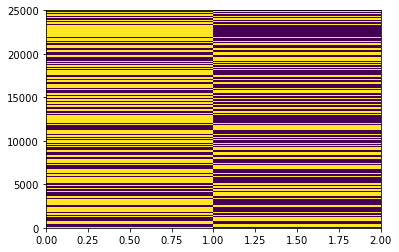

In [10]:
# Plot class districution 
plt.pcolormesh(train_data[1])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 512)]        0                                            
__________________________________________________________________________________________________
bert_layer (KerasLayer)         [(None, 768), (None, 109482241   input_ids[0][0]                  
                                                                 input_masks[0][0]            

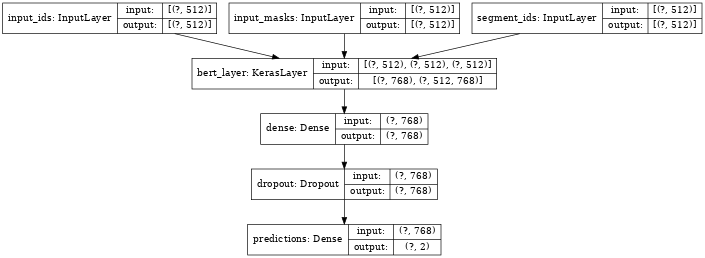

In [11]:
# Modelling fine-tuned Bert model
pre_trained_bert_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"
model = iBert.nlp_model(pre_trained_bert_url, 2)
model.summary()
tf.keras.utils.plot_model(model, "model_bert.png", show_shapes=True, dpi=48)

In [12]:
# Get Bert tokenizer
tokenizer = iBert.create_tonkenizer(model.layers[3])

100%|██████████| 24000/24000 [01:26<00:00, 278.21it/s]


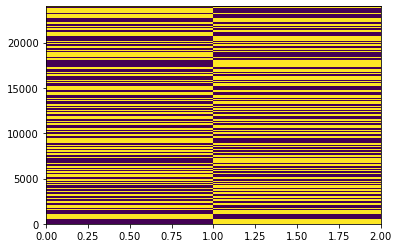

In [13]:
# Prepare model required final input and output 
train_final_data = train_data 
# split train data run
if RUN_TYPE is model_utils.RunType.SPLIT:
    train_final_data = train_data[0][:SPLIT_TRAIN_SIZE], train_data[1][:SPLIT_TRAIN_SIZE], train_data[2][:SPLIT_TRAIN_SIZE]
# test run
if RUN_TYPE is model_utils.RunType.SHORT:
    train_final_data = train_data[0][:TEST_RUN_SIZE], train_data[1][:TEST_RUN_SIZE], train_data[2][:TEST_RUN_SIZE]
    
x_train = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(train_final_data[0], tokenizer)
y_train = train_final_data[1]
plt.pcolormesh(y_train)


## Model training

In [14]:
# Model parameter set
BATCH_SIZE = 8
EPOCHS = 4
LRATE = 2e-5
LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

# Specify model name
root_name = 'model_bert'
if RUN_TYPE is model_utils.RunType.FULL:
    model_file_name = root_name + '_25000_'
if RUN_TYPE is model_utils.RunType.SPLIT:
    model_file_name = root_name + '_' + str(SPLIT_TRAIN_SIZE) + '_'
model_name = model_file_name + 'epoch_' + str(EPOCHS) + ".h5"
if RUN_TYPE is model_utils.RunType.SHORT:
    model_name = "tmp_"+ root_name +'_'+ 'epoch_' + str(EPOCHS) + ".h5"

In [15]:
x_train[0].shape

(24000, 512)

In [16]:
y_train.shape

(24000, 2)

Epoch 1/4
3000/3000 [==============================] - 995s 332ms/step - loss: 0.2398 - accuracy: 0.9041
Epoch 2/4
3000/3000 [==============================] - 996s 332ms/step - loss: 0.1234 - accuracy: 0.9571
Epoch 3/4
3000/3000 [==============================] - 995s 332ms/step - loss: 0.0659 - accuracy: 0.9780
Epoch 4/4
3000/3000 [==============================] - 995s 332ms/step - loss: 0.0410 - accuracy: 0.9872
dict_keys(['loss', 'accuracy'])


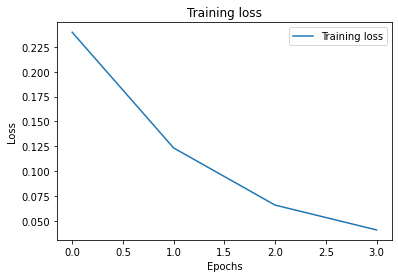

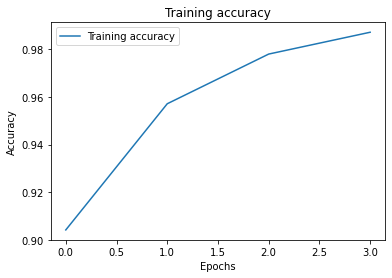

In [17]:
#Train the model
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

#Use Adam optimizer to minimize the categorical_crossentropy loss
opt = Adam(learning_rate=LRATE)
model.compile(optimizer=opt, 
              loss=LOSS,
              metrics=[METRICS])

# Fit the data to the model
history = model.fit(x_train, y_train,
                    #validation_data=(X_test, y_test),
                    #validation_split=0.2, # Important: in production, use all training data
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    #callbacks=[tensorboard_callback],
                    verbose = 1)


# Save the trained model
model.save(model_name)
model_utils.get_history(history)

## Analysis of model performance

100%|██████████| 1000/1000 [00:03<00:00, 297.55it/s]


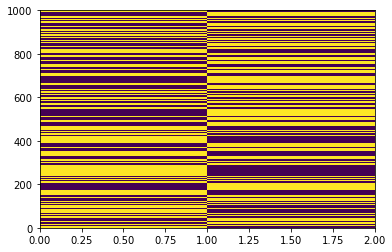

In [18]:
# Preprocess 25K test data. Return review texts with label (positive or negative). 
# Test data for full run is not shuffled. Test data for short test run is shuffled.
# For split run, use train portion of data in testing.

need_shuffle = False
if RUN_TYPE is model_utils.RunType.SHORT:
    need_shuffle = True
test_final_data = test_data = text_test, label_test, df_fit_test = imdb.get_fit_data(df_test, need_shuffle)

# split train data in test for split run
if RUN_TYPE is model_utils.RunType.SPLIT:
    test_final_data = train_data[0][SPLIT_TRAIN_SIZE:], train_data[1][SPLIT_TRAIN_SIZE:], train_data[2][SPLIT_TRAIN_SIZE:]
# get smaller data size for short test run
if RUN_TYPE is model_utils.RunType.SHORT:
    test_final_data = test_data[0][:TEST_RUN_SIZE], test_data[1][:TEST_RUN_SIZE], test_data[2][:TEST_RUN_SIZE]

x_test = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(test_final_data[0], tokenizer)
y_test = test_final_data[1]
plt.pcolormesh(y_test)


In [19]:
RUN_TYPE is model_utils.RunType.SPLIT

True

In [20]:
# Get predictions for test data
prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)

8/8 [==============================] - 11s 1s/step - loss: 0.2015 - accuracy: 0.9400
[0.20147709548473358, 0.9399999976158142]


In [21]:
RUN_TYPE is model_utils.RunType.SPLIT

True

In [22]:
# Create result file
result_file_root_name = root_name + '_result'
model_utils.output_result(test_final_data[2], result_file_root_name, RUN_TYPE.value, prediction_prob, SPLIT_TRAIN_SIZE)

In [23]:
len(test_final_data[2])

1000

100%|██████████| 25000/25000 [01:22<00:00, 304.66it/s]


196/196 [==============================] - 321s 2s/step - loss: 0.2092 - accuracy: 0.9402
[0.2091795653104782, 0.9402400255203247]


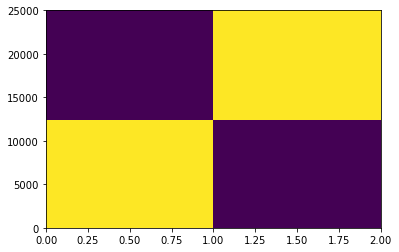

In [24]:
# Run prediction and create result file for 25k test data for split run
if RUN_TYPE is model_utils.RunType.SPLIT:
    x_test = x_input1, x_input2, x_input3 = iBert.convert_sentences_to_features(test_data[0], tokenizer)
    y_test = test_data[1]
    plt.pcolormesh(y_test)
    prediction_prob = model_utils.get_model_performance(model_name, x_test, y_test, 128)
    model_utils.output_result(test_data[2], result_file_root_name, RUN_TYPE.value, prediction_prob, SPLIT_TRAIN_SIZE)